In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# Function for loading images and flattening them into a matrix
def loadimgstomat(path, sample):
    files = os.listdir(path)
    plt.figure(figsize=(20,10))
    for i in range(sample):
        image = cv2.resize(cv2.imread(os.path.join(path,files[i]),1),(100,100),interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pixels = np.array(image)
        plt.subplot(4,4,i+1)
        plt.imshow(pixels)
        plt.axis('off')
    plt.suptitle('Sample 16 '+ path.split(sep='/')[-1]+' images in '+' the given dataset')    
    plt.show()
    images = cv2.resize(cv2.imread(os.path.join(path,files[0]),0),(100,100),interpolation = cv2.INTER_AREA)
    images = images.flatten()
    for fname in files[1::]:
        img = cv2.resize(cv2.imread(os.path.join(path,fname),0),(100,100),interpolation = cv2.INTER_AREA)
        if img is not None:
            images = np.vstack((images,img.flatten()))
    return images

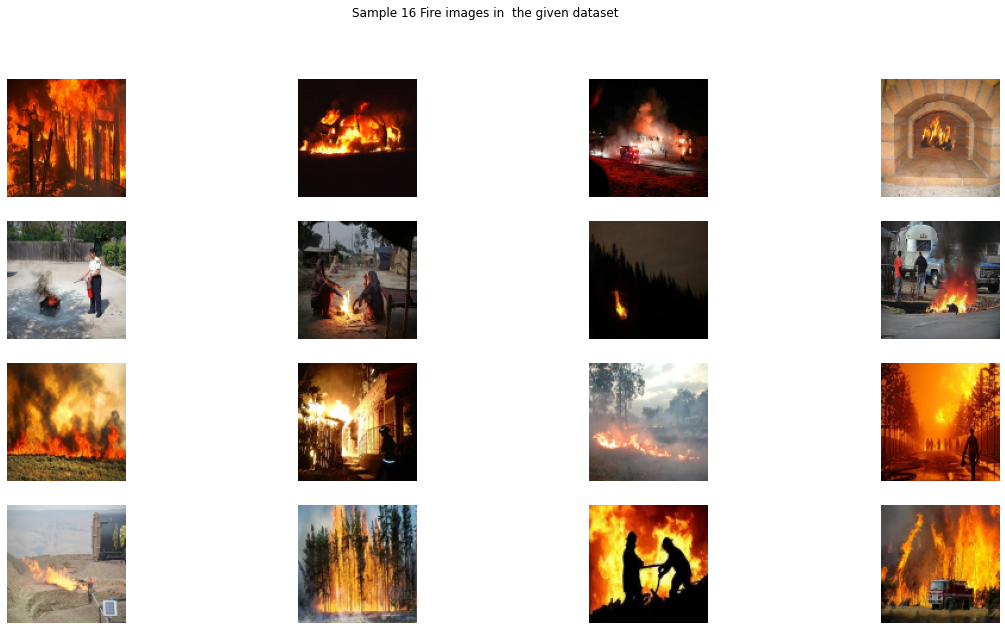

Fire images matrix shape: (70, 10000)


In [3]:
# Fire images loading from directory
path = 'C:/Users/decim/OneDrive/Desktop/Fire Detection Model master/L/Dataset/Fire'
fire = loadimgstomat(path , 16)
print('Fire images matrix shape:',fire.shape)

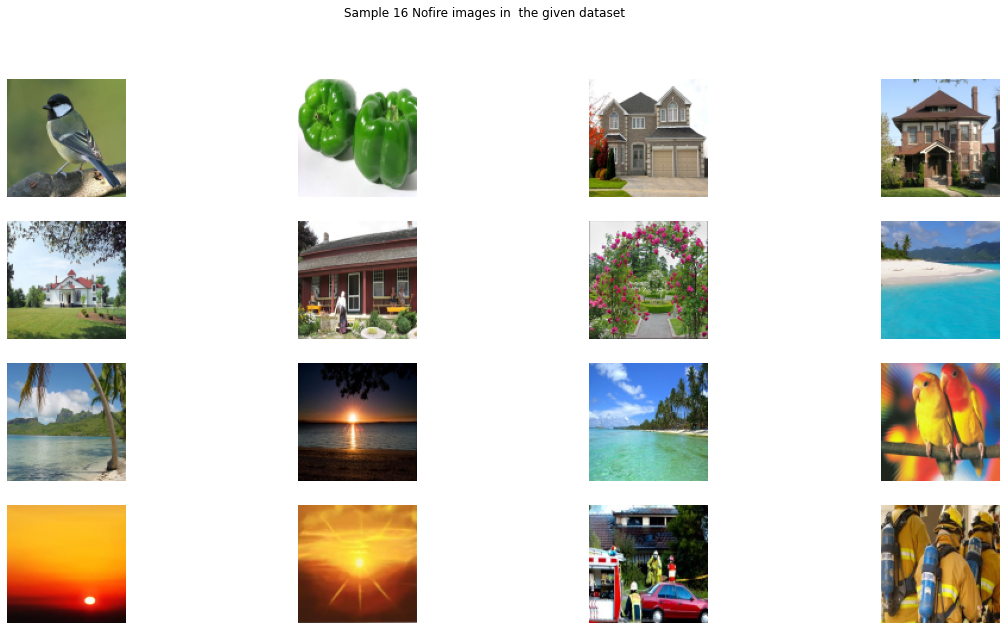

Fire images matrix shape: (70, 10000)


In [4]:
# No fire images loading from directory
path = 'C:/Users/decim/OneDrive/Desktop/Fire Detection Model master/L/Dataset/Nofire'
nofire = loadimgstomat(path, 16)
print('Fire images matrix shape:',nofire.shape)

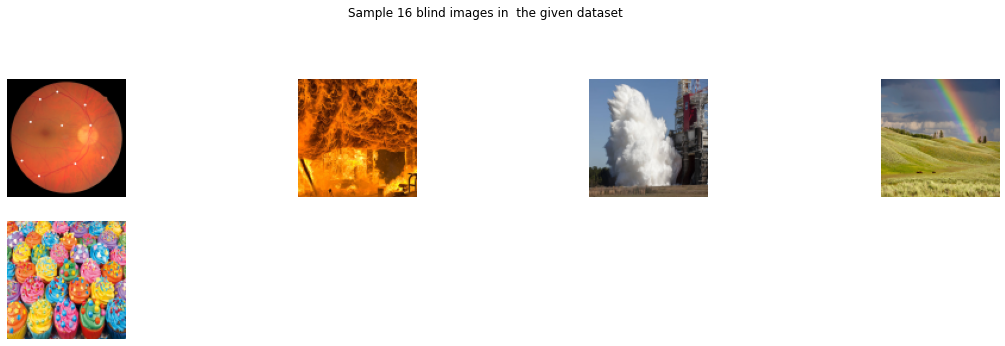

blend images matrix shape: (5, 10000)


In [5]:
path = 'C:/Users/decim/OneDrive/Desktop/Fire Detection Model master/L/Dataset/blind'
blend = loadimgstomat(path , 5 )
print('blend images matrix shape:',blend.shape)
y_blend = ['No', 'Yes', 'No', 'No', 'No']

In [6]:
# Constructing feature matrix and its response variable
X = np.vstack((fire,nofire))
y = np.array(['Yes']*len(fire)+['No']*len(nofire))

In [7]:
# Feature dimensionality reduction by ExtraTree classifier method
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=60,random_state=145)
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True,threshold=1e-3)
Xtr = model.transform(X)
Xtr.shape

(140, 170)

In [8]:
# Priniting the top 10 feature with highest importance score as ranked by ExtraTree classifier
print('Top 10 features by importance scores and their indexes:')
pd.Series(clf.feature_importances_).sort_values(ascending=False).head(10)

Top 10 features by importance scores and their indexes:


136     0.006127
469     0.004662
1207    0.004538
7394    0.004341
77      0.003555
1406    0.003486
787     0.003412
4906    0.003303
2811    0.003276
471     0.003250
dtype: float64

In [9]:
# Splitting data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtr, y, test_size=0.2, random_state=99)
print('Train set feature shape:',X_train.shape)
print('Test set feature shape:',X_test.shape)

Train set feature shape: (112, 170)
Test set feature shape: (28, 170)


In [10]:
# Accuracy, specificity, sensitivity and MCC calculation in one function from confusion matrix
def metrics(cmat):
    TN = cmat[0][0]
    TP = cmat[1][1]
    FP = cmat[0][1]
    FN = cmat[1][0]
    sen = 100*TP/(TP+TN)
    spec = 100*TN/(TN+FP)
    acc = 100*(TP+TN)/(TP+FP+TN+FN)
    mcc = (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    return sen,spec,acc,mcc

### Artificial Neural Network(Multi-Layer Perceptron) model fitting

In [11]:
from sklearn.neural_network import MLPClassifier
mlpmodel = MLPClassifier(random_state=204,solver='lbfgs',activation='relu',hidden_layer_sizes=(25,10),\
                         max_iter=1000,alpha=1e-4).fit(X_train, y_train)
print('MLP neural network model parameters:\n',mlpmodel.get_params())

MLP neural network model parameters:
 {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (25, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 204, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


C:\Users\decim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


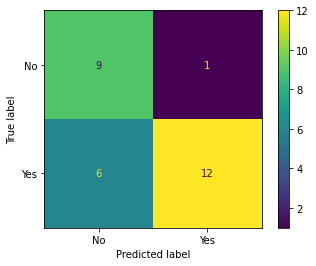

Sensitivity(%): 57.1
Specificity(%): 90.0
Accuracy(%): 75.0
Matthews correlation coefficient(MCC): 0.544


In [12]:
# Results in test set
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
ypreds = mlpmodel.predict(X_test)
mlpprobs = mlpmodel.predict_proba(X_test)[:,1]
plot_confusion_matrix(mlpmodel,X_test, y_test)
plt.show()
cmat = confusion_matrix(y_test, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))
fpr1, tpr1, thresholds1 = roc_curve(y_test, mlpprobs, pos_label='Yes')

In [13]:
# results in train set
ypreds = mlpmodel.predict(X_train)
cmat = confusion_matrix(y_train, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 46.4
Specificity(%): 100.0
Accuracy(%): 100.0
Matthews correlation coefficient(MCC): 1.000


In [14]:
# Code for fitting MLP neural network classifier on same train set and then evaluating on an unlabelled test set by Pipeline
from sklearn.pipeline import Pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
mlppipe = Pipeline([('preprocess',SelectFromModel(ExtraTreesClassifier(n_estimators=60,random_state=145),\
                                                threshold=1e-3)),\
                    ('MLP', MLPClassifier(random_state=204,solver='lbfgs',activation='relu',hidden_layer_sizes=(25,10),\
                         max_iter=1000,alpha=1e-4))])
mlppipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=60,
                                                                random_state=145),
                                 threshold=0.001)),
                ('MLP',
                 MLPClassifier(hidden_layer_sizes=(25, 10), max_iter=1000,
                               random_state=204, solver='lbfgs'))])

In [15]:
mlppipe.predict(X_test)

array(['No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes',
       'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No',
       'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No'], dtype='<U3')

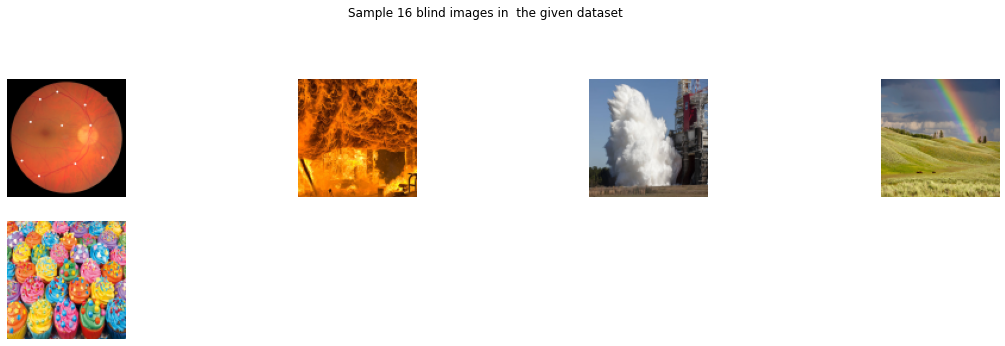

array(['Yes', 'No', 'Yes', 'No', 'No'], dtype='<U3')

In [16]:
# test on blend data set 
blend = loadimgstomat(path , 5)
ypreds = mlppipe.predict(blend)
ypreds 

In [17]:
# results in blind set
cmat = confusion_matrix(y_blend, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 0.0
Specificity(%): 50.0
Accuracy(%): 40.0
Matthews correlation coefficient(MCC): -0.408


### Adaboost classifier model fitting

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [18]:
from sklearn.ensemble import AdaBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(Xtr, y, test_size=0.2, random_state=99)
adaboost = AdaBoostClassifier(n_estimators=60, random_state=125,learning_rate=0.5).fit(X_train,y_train)
print('AdaBoost classifier model parameters:\n',adaboost.get_params())

AdaBoost classifier model parameters:
 {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.5, 'n_estimators': 60, 'random_state': 125}


C:\Users\decim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


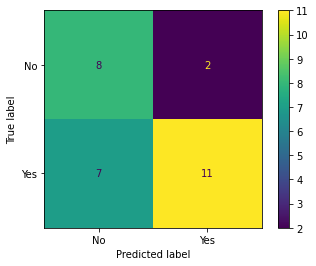

Sensitivity(%): 57.9
Specificity(%): 80.0
Accuracy(%): 67.9
Matthews correlation coefficient(MCC): 0.395


In [19]:
ypreds = adaboost.predict(X_test)
adbprobs = adaboost.predict_proba(X_test)[:,1]
plot_confusion_matrix(adaboost,X_test, y_test)
plt.show()
cmat = confusion_matrix(y_test, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))
fpr2, tpr2, thresholds2 = roc_curve(y_test, adbprobs, pos_label='Yes')

In [20]:
# results in train set
ypreds = adaboost.predict(X_train)
cmat = confusion_matrix(y_train, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 46.4
Specificity(%): 100.0
Accuracy(%): 100.0
Matthews correlation coefficient(MCC): 1.000


In [21]:
# Code for fitting Adaboost classifier on same train set and then evaluating on an unlabelled test set by Pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
adapipe = Pipeline([('preprocess',SelectFromModel(ExtraTreesClassifier(n_estimators=60,random_state=145),\
                                                threshold=1e-3)),\
                    ('adaboost', AdaBoostClassifier(n_estimators=60, random_state=125,learning_rate=0.5))])
adapipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=60,
                                                                random_state=145),
                                 threshold=0.001)),
                ('adaboost',
                 AdaBoostClassifier(learning_rate=0.5, n_estimators=60,
                                    random_state=125))])

In [22]:
adapipe.predict(X_test)

array(['No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No',
       'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No'], dtype='<U3')

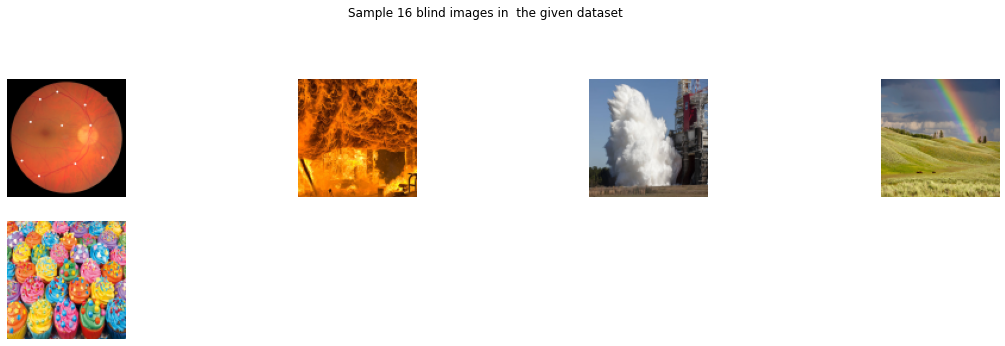

array(['Yes', 'No', 'No', 'Yes', 'No'], dtype='<U3')

In [23]:
# test on blend data set 
blend = loadimgstomat(path , 5)
ypreds = adapipe.predict(blend)
ypreds 

In [24]:
# results in blind set
cmat = confusion_matrix(y_blend, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 0.0
Specificity(%): 50.0
Accuracy(%): 40.0
Matthews correlation coefficient(MCC): -0.408


### Bagging classifier model fitting


A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions to form a final prediction. 

In [25]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
X_train, X_test, y_train, y_test = train_test_split(Xtr, y, test_size=0.2, random_state=99)
bagmodel = BaggingClassifier(base_estimator=SVC(),n_estimators=60, random_state=125).fit(X_train,y_train)
print('Bagging classifier model parameters:\n',bagmodel.get_params())

Bagging classifier model parameters:
 {'base_estimator__C': 1.0, 'base_estimator__break_ties': False, 'base_estimator__cache_size': 200, 'base_estimator__class_weight': None, 'base_estimator__coef0': 0.0, 'base_estimator__decision_function_shape': 'ovr', 'base_estimator__degree': 3, 'base_estimator__gamma': 'scale', 'base_estimator__kernel': 'rbf', 'base_estimator__max_iter': -1, 'base_estimator__probability': False, 'base_estimator__random_state': None, 'base_estimator__shrinking': True, 'base_estimator__tol': 0.001, 'base_estimator__verbose': False, 'base_estimator': SVC(), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 60, 'n_jobs': None, 'oob_score': False, 'random_state': 125, 'verbose': 0, 'warm_start': False}


C:\Users\decim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


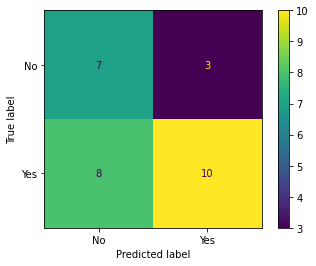

Sensitivity(%): 58.8
Specificity(%): 70.0
Accuracy(%): 60.7
Matthews correlation coefficient(MCC): 0.246


In [26]:
# results in test set
ypreds = bagmodel.predict(X_test)
bagprobs = bagmodel.predict_proba(X_test)[:,1]
plot_confusion_matrix(bagmodel,X_test, y_test)
plt.show()
cmat = confusion_matrix(y_test, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))
fpr3, tpr3, thresholds3 = roc_curve(y_test, bagprobs, pos_label='Yes')

In [27]:
# results in train set
ypreds = bagmodel.predict(X_train)
cmat = confusion_matrix(y_train, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 44.4
Specificity(%): 91.7
Accuracy(%): 88.4
Matthews correlation coefficient(MCC): 0.767


In [28]:
# Code for fitting bagging classifier on same train set and then evaluating on an unlabelled test set by Pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
bagpipe = Pipeline([('preprocess',SelectFromModel(ExtraTreesClassifier(n_estimators=60,random_state=145),\
                                                threshold=1e-3)),\
                    ('clf', BaggingClassifier(base_estimator=SVC(),n_estimators=10, random_state=0))])
bagpipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=60,
                                                                random_state=145),
                                 threshold=0.001)),
                ('clf',
                 BaggingClassifier(base_estimator=SVC(), random_state=0))])

In [29]:
bagpipe.predict(X_test)

array(['Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No',
       'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No'], dtype='<U3')

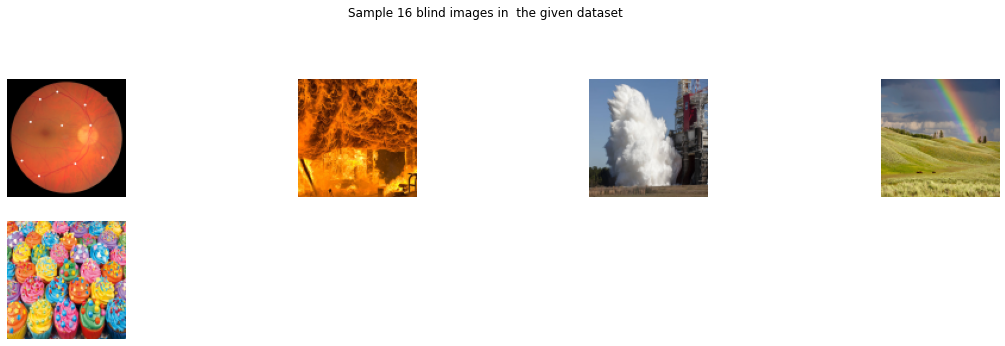

array(['Yes', 'No', 'No', 'No', 'No'], dtype='<U3')

In [30]:
# test on blend data set
blend = loadimgstomat(path ,5)
ypreds = bagpipe.predict(blend)
ypreds

In [31]:
# results in blind set
cmat = confusion_matrix(y_blend, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 0.0
Specificity(%): 75.0
Accuracy(%): 60.0
Matthews correlation coefficient(MCC): -0.250


### Gradient Boosting Classifier  model fitting

Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting.

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(Xtr, y, test_size=0.2, random_state=99)
gbcmodel = GradientBoostingClassifier(n_estimators=60, learning_rate=0.5,
           max_depth=1, random_state=0).fit(X_train,y_train)
print('Gradient Boosting classifier model parameters:\n',gbcmodel.get_params())

Gradient Boosting classifier model parameters:
 {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.5, 'loss': 'deviance', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 60, 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


C:\Users\decim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


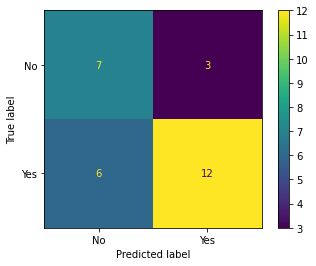

Sensitivity(%): 63.2
Specificity(%): 70.0
Accuracy(%): 67.9
Matthews correlation coefficient(MCC): 0.352


In [33]:
# results in test set
ypreds = gbcmodel.predict(X_test)
gbcprobs = gbcmodel.predict_proba(X_test)[:,1]
plot_confusion_matrix(gbcmodel,X_test, y_test)
plt.show()
cmat = confusion_matrix(y_test, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))
fpr4, tpr4, thresholds4 = roc_curve(y_test, gbcprobs, pos_label='Yes')

In [34]:
# results in train set
ypreds = gbcmodel.predict(X_train)
cmat = confusion_matrix(y_train, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 46.4
Specificity(%): 100.0
Accuracy(%): 100.0
Matthews correlation coefficient(MCC): 1.000


In [35]:
# Code for fitting Random forest classifier on same train set and then evaluating on an unlabelled test set by Pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
gbcpipe = Pipeline([('preprocess',SelectFromModel(ExtraTreesClassifier(n_estimators=60,random_state=145),\
                                                threshold=1e-3)),\
                    ('gbc', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
           max_depth=1, random_state=0))])
gbcpipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=60,
                                                                random_state=145),
                                 threshold=0.001)),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            random_state=0))])

In [36]:
gbcpipe.predict(X_test)

array(['No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes',
       'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No',
       'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No'], dtype='<U3')

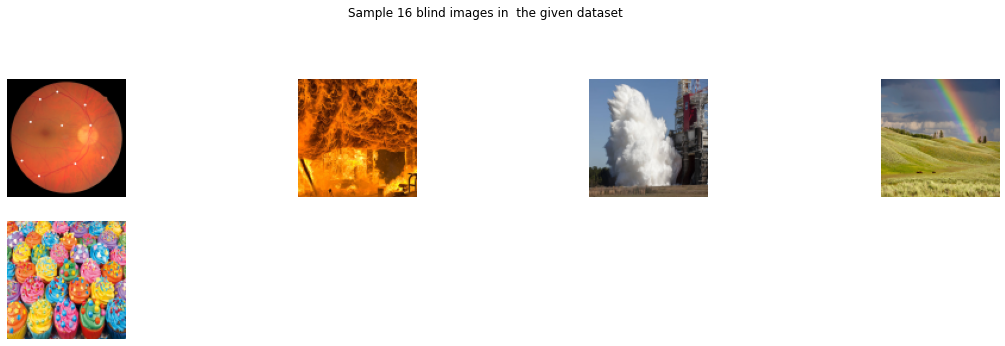

array(['Yes', 'No', 'No', 'Yes', 'No'], dtype='<U3')

In [37]:
# test on blend data set
blend = loadimgstomat(path ,5)
ypreds = gbcpipe.predict(blend)
ypreds

In [38]:
# results in blind set
cmat = confusion_matrix(y_blend, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 0.0
Specificity(%): 50.0
Accuracy(%): 40.0
Matthews correlation coefficient(MCC): -0.408


### Random forest classifier model fitting


A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [39]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(Xtr, y, test_size=0.2, random_state=99)
rfmodel = RandomForestClassifier(max_depth=20, random_state=455,n_estimators=60,max_features='sqrt',\
                                 ccp_alpha=1e-3).fit(X_train,y_train)
print('Random forest classifier model parameters:\n',rfmodel.get_params())

Random forest classifier model parameters:
 {'bootstrap': True, 'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 60, 'n_jobs': None, 'oob_score': False, 'random_state': 455, 'verbose': 0, 'warm_start': False}


C:\Users\decim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


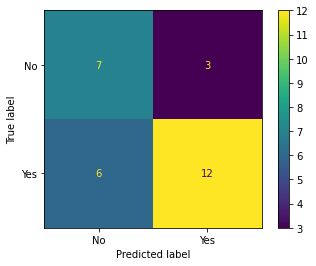

Sensitivity(%): 63.2
Specificity(%): 70.0
Accuracy(%): 67.9
Matthews correlation coefficient(MCC): 0.352


In [40]:
# results in test set
ypreds = rfmodel.predict(X_test)
rfprobs = rfmodel.predict_proba(X_test)[:,1]
plot_confusion_matrix(rfmodel,X_test, y_test)
plt.show()
cmat = confusion_matrix(y_test, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))
fpr5, tpr5, thresholds5 = roc_curve(y_test, rfprobs, pos_label='Yes')

In [41]:
# results in train set
ypreds = rfmodel.predict(X_train)
cmat = confusion_matrix(y_train, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 46.4
Specificity(%): 100.0
Accuracy(%): 100.0
Matthews correlation coefficient(MCC): 1.000


In [42]:
# Code for fitting Random forest classifier on same train set and then evaluating on an unlabelled test set by Pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
rfpipe = Pipeline([('preprocess',SelectFromModel(ExtraTreesClassifier(n_estimators=60,random_state=145),\
                                                threshold=1e-3)),\
                    ('rf', RandomForestClassifier(max_depth=20, random_state=455,n_estimators=60,max_features='sqrt',\
                                 ccp_alpha=1e-3))])
rfpipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=60,
                                                                random_state=145),
                                 threshold=0.001)),
                ('rf',
                 RandomForestClassifier(ccp_alpha=0.001, max_depth=20,
                                        max_features='sqrt', n_estimators=60,
                                        random_state=455))])

In [43]:
rfpipe.predict(X_test)

array(['No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No',
       'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No'], dtype='<U3')

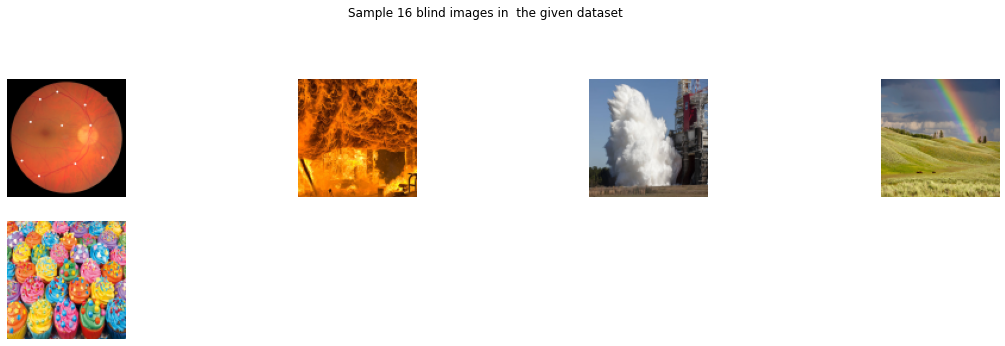

array(['Yes', 'No', 'No', 'No', 'No'], dtype='<U3')

In [44]:
# test on blend data set 
blend = loadimgstomat(path ,5)
ypreds = rfpipe.predict(blend)
ypreds

In [45]:
# results in blind set
cmat = confusion_matrix(y_blend, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 0.0
Specificity(%): 75.0
Accuracy(%): 60.0
Matthews correlation coefficient(MCC): -0.250


### HistGradient Boosting Classifier model fitting

Histogram-based Gradient Boosting Classification Tree.



In [46]:
from sklearn.ensemble import HistGradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(Xtr, y, test_size=0.2, random_state=99)
Hgbmodel = HistGradientBoostingClassifier().fit(X_train,y_train)
print('HistGradient Boosting classifier model parameters:\n',Hgbmodel.get_params())

HistGradient Boosting classifier model parameters:
 {'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'auto', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


C:\Users\decim\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


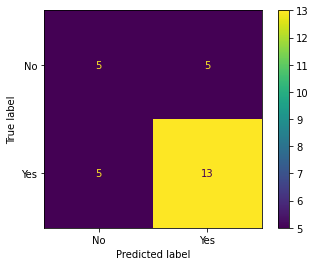

Sensitivity(%): 72.2
Specificity(%): 50.0
Accuracy(%): 64.3
Matthews correlation coefficient(MCC): 0.222


In [47]:
# results in test set
ypreds = Hgbmodel.predict(X_test)
hgbprobs = Hgbmodel.predict_proba(X_test)[:,1]
plot_confusion_matrix(Hgbmodel,X_test, y_test)
plt.show()
cmat = confusion_matrix(y_test, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))
fpr6, tpr6, thresholds6 = roc_curve(y_test, hgbprobs, pos_label='Yes')

In [48]:
# results in train set
ypreds = Hgbmodel.predict(X_train)
cmat = confusion_matrix(y_train, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 46.4
Specificity(%): 100.0
Accuracy(%): 100.0
Matthews correlation coefficient(MCC): 1.000


In [49]:
# Code for fitting Random forest classifier on same train set and then evaluating on an unlabelled test set by Pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
hgbpipe = Pipeline([('preprocess',SelectFromModel(ExtraTreesClassifier(n_estimators=60,random_state=145),\
                                                threshold=1e-3)),\
                    ('hgv', HistGradientBoostingClassifier())])
hgbpipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=60,
                                                                random_state=145),
                                 threshold=0.001)),
                ('hgv', HistGradientBoostingClassifier())])

In [50]:
hgbpipe.predict(X_test)

array(['No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No',
       'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No'], dtype='<U3')

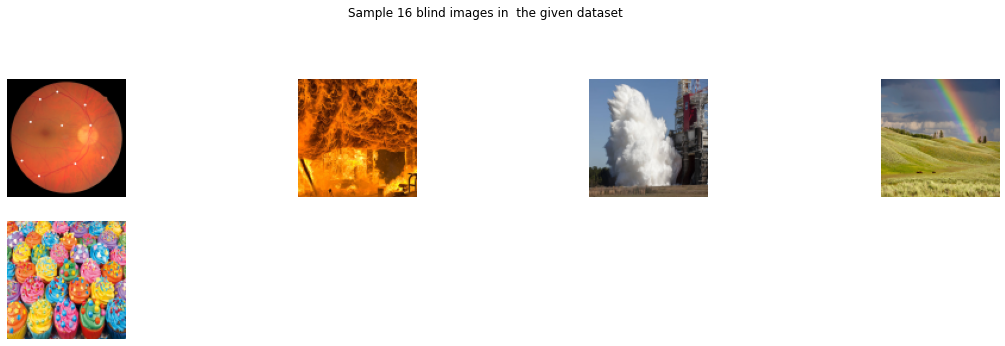

array(['Yes', 'No', 'Yes', 'Yes', 'No'], dtype='<U3')

In [51]:
# test on blend data set 
blend = loadimgstomat(path ,5)
ypreds = hgbpipe.predict(blend)
ypreds

In [52]:
# results in blind set
cmat = confusion_matrix(y_blend, ypreds)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 0.0
Specificity(%): 25.0
Accuracy(%): 20.0
Matthews correlation coefficient(MCC): -0.612


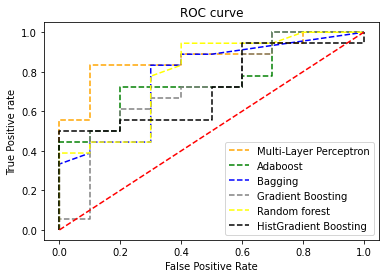

In [53]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label='Yes')

# plotting roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Multi-Layer Perceptron')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Adaboost')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='Bagging')
plt.plot(fpr4, tpr4, linestyle='--',color='gray', label='Gradient Boosting')
plt.plot(fpr5, tpr5, linestyle='--',color='yellow', label='Random forest')
plt.plot(fpr6, tpr6, linestyle='--',color='black', label='HistGradient Boosting')
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### Keras Deep Learning Model Training

In [54]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

In [55]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'C:/Users/decim/OneDrive/Desktop/Fire Detection Model master/L/Dataset/train'
validation_data_dir = 'C:/Users/decim/OneDrive/Desktop/Fire Detection Model master/L/Dataset/test'
nb_train_samples = 104
nb_validation_samples = 36
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [56]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 104 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [57]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [58]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [59]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)


C:\Users\decim\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
6/6 [==============================] - 3s 420ms/step - loss: 1.0390 - accuracy: 0.6023 - val_loss: 0.5773 - val_accuracy: 0.7500
Epoch 2/50
6/6 [==============================] - 3s 383ms/step - loss: 0.6972 - accuracy: 0.6250 - val_loss: 0.6277 - val_accuracy: 0.5625
Epoch 3/50
6/6 [==============================] - 2s 375ms/step - loss: 0.6923 - accuracy: 0.7045 - val_loss: 0.6528 - val_accuracy: 0.6562
Epoch 4/50
6/6 [==============================] - 2s 373ms/step - loss: 0.5738 - accuracy: 0.7159 - val_loss: 0.5620 - val_accuracy: 0.6562
Epoch 5/50
6/6 [==============================] - 2s 373ms/step - loss: 0.5997 - accuracy: 0.6477 - val_loss: 0.5841 - val_accuracy: 0.6562
Epoch 6/50
6/6 [==============================] - 2s 319ms/step - loss: 0.5162 - accuracy: 0.7500 - val_loss: 0.5685 - val_accuracy: 0.6250
Epoch 7/50
6/6 [==============================] - 2s 340ms/step - loss: 0.5515 - accuracy: 0.6932 - val_loss: 0.5766 - val_accuracy: 0.6875
Epoch 8/50
6/6 [====

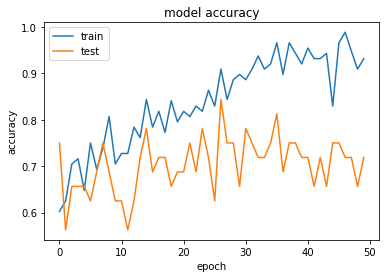

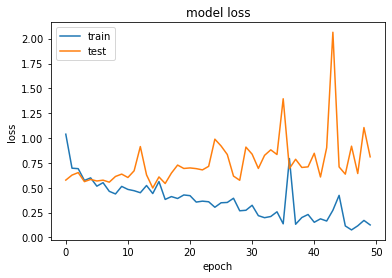

In [60]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [61]:
model.save_weights('first_try.h5')

In [62]:
# Lists for missed fire images and missed non-fire images
msd_fire = []
msd_nofire = []

# Iterating through all 
for j in range(1):
    img, label = validation_generator[j] 
    pred = np.round(model.predict(img)).flatten()
    bool_list = label == pred

    # bool_list is False when there is misclassification 
    for i, e in enumerate(bool_list):
        if e == False:
            
            # separating labels (fire and non-fire)
            if label[i] == 0:
                msd_fire.append(img[i])
            else:
                msd_nofire.append(img[i])

<ipython-input-63-13833ecaebcb>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


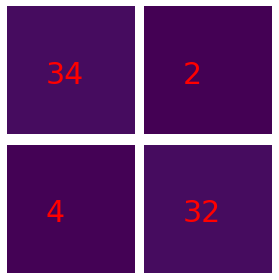

In [63]:
# total number of sample in test set in each class 
n_class = 36

# number of misclassified fire and non-fire images 
nm_fire, nm_nofire = len(msd_fire), len(msd_nofire)

# confusion matrix (flattened)
conf_mat = [n_class-nm_fire, nm_fire, nm_nofire, n_class-nm_nofire]

# visualization of confusion matrix 
fig = plt.figure(figsize=(4, 4))
for i, j in enumerate(conf_mat):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow([[j]], vmin=0, vmax=1000, cmap='viridis')
    ax.text(-0.2, 0.1, j, c='r', fontsize=30)
    ax.axis('off')

# bringing blocks tighter 
fig.tight_layout()
fig.show()

#### sensitivity 94.6% 
#### specificity 97.1% 
#### accuracy 95.8% 
####  MCC 0.917

In [64]:
import tensorflow as tf
from tensorflow import keras
image_size = (150, 150)

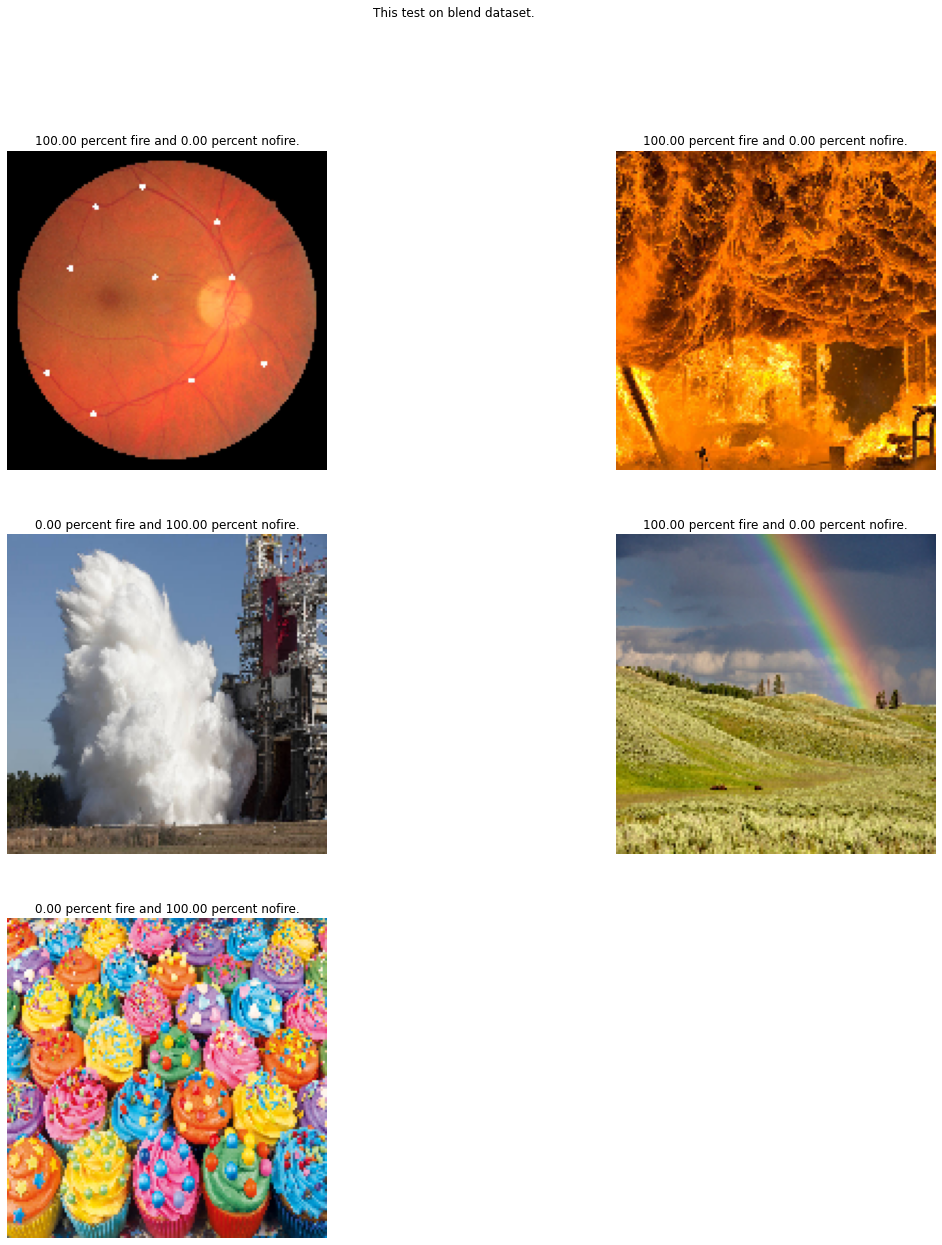

In [65]:
path = 'C:/Users/decim/OneDrive/Desktop/Fire Detection Model master/L/Dataset/blind'
files = os.listdir(path)
plt.figure(figsize=(20,20))
score = []
for i in range(5):
    img = keras.preprocessing.image.load_img(os.path.join(path,files[i]), target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    score = predictions[0]
    ax =  plt.subplot(3,2,i+1)
    ax.axis('off')
    ax.set_title("%.2f percent fire and %.2f percent nofire."
        % (100 * (1 - score), 100 * score))
    plt.imshow(img)
plt.axis('off')
plt.suptitle("This test on blend dataset.")    
plt.show()

In [66]:
y_prid = ['Yes', 'No', 'Yes', 'Yes', 'No']

In [67]:
# results in blind set
cmat = confusion_matrix(y_blend, y_prid)
sen,spec,acc,mcc = metrics(cmat)
print('Sensitivity(%%): %.1f' %(sen))
print('Specificity(%%): %.1f' %(spec))
print('Accuracy(%%): %.1f' %(acc))
print('Matthews correlation coefficient(MCC): %.3f' %(mcc))

Sensitivity(%): 0.0
Specificity(%): 25.0
Accuracy(%): 20.0
Matthews correlation coefficient(MCC): -0.612
